In [18]:
from IPython.display import display
import os

if "SSH_CONNECTION" in os.environ:
    display("Running via SSH")
else:
    display("Running locally")

'Running locally'

In [19]:
import sys
import os

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/TB-PNCA-GNN') if "SSH_CONNECTION" not in os.environ else os.path.join('..', '/mnt/alphafold-volume-1/dylan2/repos/tb-pnca-gnn')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

import datetime
import random

import numpy as np
import pandas as pd
import copy
import pickle

import torch
from torch_geometric.data import Data

import wandb

import sbmlcore
import sbmlsim
import gumpy

import warnings
warnings.filterwarnings('ignore')

from src import run_model, protein_graph, gcn_model, evaluation

%load_ext autoreload
%autoreload 2

%aimport src

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%reload_ext autoreload
%autoreload 2

In [21]:
torch.cuda.is_available()

False

### Create Train and Test Sequences from Carter paper

In [22]:
reference = gumpy.Genome('../data/NC_000962.3.gbk')
pnca = reference.build_gene('pncA')

In [23]:
# recreate train/test dataset from pncA paper
pnca_paper_dataset = pd.read_csv('../data/ds-traintest-phen.csv')
pnca_paper_dataset.CONSISTENT_PHENOTYPE.value_counts()

CONSISTENT_PHENOTYPE
R    349
S    315
Name: count, dtype: int64

In [24]:
def split_mutation(row):
    return pd.Series([row.MUTATION[0], int(row.MUTATION[1:-1]), row.MUTATION[-1]])

pnca_paper_dataset[['REF','AMINO_ACID','ALT']] = pnca_paper_dataset.apply(split_mutation,axis=1)

In [25]:
# get original train and test mutations from Carter paper dataset

with open('../data/original-ds-muts.pkl', 'rb') as f:
    original_ds_muts = pickle.load(f)

In [26]:
# from sklearn.model_selection import train_test_split

mutations_dict = {}

# mutations_dict['train'], mutations_dict['test'] = train_test_split(pnca_paper_dataset, test_size=0.3, random_state=42)
mutations_dict['train'] = pnca_paper_dataset[pnca_paper_dataset.MUTATION.isin(original_ds_muts['train'])]
mutations_dict['test'] = pnca_paper_dataset[pnca_paper_dataset.MUTATION.isin(original_ds_muts['test'])]

### Augment Train and Test datasets with SBMLSsim

In [27]:
def get_muts_list(df):
    r_list = list(df[df.CONSISTENT_PHENOTYPE=='R'].MUTATION.drop_duplicates())
    s_list = list(df[df.CONSISTENT_PHENOTYPE=='S'].MUTATION.drop_duplicates())
    r_list = ['pncA@' + x for x in r_list]
    s_list = ['pncA@' + x for x in s_list]
    return r_list, s_list

In [28]:
train_res_list, train_sus_list = get_muts_list(mutations_dict['train'])
test_res_list, test_sus_list = get_muts_list(mutations_dict['test'])

In [29]:
print('Num resistant mutations in train:',len(train_res_list), 'Num susceptible mutations in train', len(train_sus_list))
print('Num resistant mutations in test:', len(test_res_list), 'Num susceptible mutations in test:', len(test_sus_list))

Num resistant mutations in train: 246 Num susceptible mutations in train 218
Num resistant mutations in test: 103 Num susceptible mutations in test: 97


In [13]:
train_batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations = train_res_list,
                        susceptible_mutations = train_sus_list,
                        genbank_file='../data/NC_000962.3.gbk'
                    )

test_batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations = test_res_list,
                        susceptible_mutations = test_sus_list,
                        genbank_file='../data/NC_000962.3.gbk'
                    )

In [14]:
seed = 42
np.random.seed(seed)
random.seed(seed)

n_samples = 10000

In [15]:
train_prop = len(train_res_list)/(len(train_res_list)+len(train_sus_list))
test_prop = len(test_res_list)/(len(test_res_list)+len(test_sus_list))

train_sequences, train_mutations = train_batch.generate(n_samples=int(n_samples*0.7),
                                                  proportion_resistant=train_prop,
                                                  n_res = 1,
                                                  n_sus = 1)

test_sequences, test_mutations = test_batch.generate(n_samples=int(n_samples*0.3),
                                                  proportion_resistant=test_prop,
                                                  n_res = 1,
                                                  n_sus = 1)

train_sequences.rename(columns = {'pncA':'allele'}, inplace=True)
test_sequences.rename(columns = {'pncA':'allele'}, inplace=True)

In [16]:
sequences_dict = {'train': train_sequences, 'test': test_sequences}

In [17]:
pd.crosstab(sequences_dict['train'].number_susceptible_mutations, sequences_dict['train'].number_resistant_mutations)

number_resistant_mutations,0,1,2,3,4,5,6,7
number_susceptible_mutations,,,,,,,,
0,0,790,413,149,27,4,0,0
1,1898,811,410,130,29,3,2,1
2,963,383,185,56,14,3,1,0
3,299,131,77,30,5,0,0,0
4,73,35,20,7,1,1,0,0
5,25,7,6,1,0,0,0,0
6,7,0,2,0,0,0,0,0
7,1,0,0,0,0,0,0,0


### Run

In [ ]:
# try with sgd, higher lr and no wd

In [6]:
cutoff_distance = 9 
# gcn params
num_node_features = 12
batch_size = 256
hidden_channels = 320
# learning_rate = 0.001
learning_rate = 1e-5
# wd = 5e-5
wd = 1e-4
epochs = 2000

# ews = 'none'
ews = '1-(dist/cutoff)'

dropout = 0.5

wt_seq = 'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS'

In [23]:
# # Create torch_geometric Data objects once to be reused each run

# pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
#                      lig_resname='PZA', 
#                      self_loops=False,
#                      cutoff_distance=cutoff_distance)

# pnca.gen_dataset(wt_seq=wt_seq,
#                     sequences=sequences_dict['train'],
#                     edge_weights=ews,
#                     normalise=True,             
#                     )
        
# train_dataset = pnca.dataset

# pnca.gen_dataset(wt_seq=wt_seq,
#             sequences=sequences_dict['test'],
#             edge_weights=ews,
#             normalise=True,             
#             )

# test_dataset = pnca.dataset
# full_dataset = train_dataset + test_dataset

# # torch.save(full_dataset, 'full_orig_dataset.pth')
# torch.save(full_dataset, 'full_dataset_v2.pth')

100%|██████████| 3000/3000 [02:50<00:00, 17.55it/s]


In [7]:
# full_dataset = torch.load('full_dataset.pth')
full_dataset = torch.load('full_dataset_v2.pth')

In [8]:
# model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
model = run_model.pnca_simpleGCN(
    # sequences=sequences_dict,
    sequences=None,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    # edge_weight_func = '1-(dist/cutoff)',
    edge_weight_func= ews,
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    dropout=dropout,
    lr_scheduling=False,
    epochs = epochs,
    dataset = full_dataset,
    normalise_ews=True,
    wandb_params={
        'use_wandb' : True,
        'wandb_project' : 'PncA Carter Dataset',
        # 'wandb_project' : 'pnca-sweep-1',
        'wandb_name' : f'dataset_removed_WTs',
        'n_samples' : n_samples
    }
)

Adjusting edge index and attaching edge weights for cutoff distance 9


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using CUDA


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: dylan-home. Use `wandb login --relogin` to force relogin


Early stopping enabled. Patience: 20. Min Delta: 0.
Epoch: 010, Train Acc: 0.6279, Test Acc: 0.6510, Train Loss: 0.6707, Test Loss: 0.6596
Epoch: 020, Train Acc: 0.5617, Test Acc: 0.5497, Train Loss: 0.6437, Test Loss: 0.6430
Epoch: 030, Train Acc: 0.6934, Test Acc: 0.6813, Train Loss: 0.6312, Test Loss: 0.6209
Epoch: 040, Train Acc: 0.7126, Test Acc: 0.6910, Train Loss: 0.6089, Test Loss: 0.6032
Epoch: 050, Train Acc: 0.7223, Test Acc: 0.6990, Train Loss: 0.5892, Test Loss: 0.5854
Epoch: 060, Train Acc: 0.5697, Test Acc: 0.5337, Train Loss: 0.5992, Test Loss: 0.6278
Epoch: 070, Train Acc: 0.7441, Test Acc: 0.7143, Train Loss: 0.5477, Test Loss: 0.5652
Epoch: 080, Train Acc: 0.7209, Test Acc: 0.7180, Train Loss: 0.5505, Test Loss: 0.5470
Epoch: 090, Train Acc: 0.7667, Test Acc: 0.7283, Train Loss: 0.5155, Test Loss: 0.5441
Epoch: 100, Train Acc: 0.7744, Test Acc: 0.7380, Train Loss: 0.4946, Test Loss: 0.5231
Epoch: 110, Train Acc: 0.7796, Test Acc: 0.7553, Train Loss: 0.4780, Test Loss

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Test Accuracy,▁▅▄▃▄▅▆▆▆▆▂▆▇▃▇▆▇▇▇▇▇▄▅▇████▇▇████████▇▄
Test F1,▃▁▂▂▂▁▁▃▃▁▃▄▆▄▅▂▅▆▇▄▇▅▆▆▆█▇▆▄▇▆██▆█▆▇█▄▆
Test Loss,▇▆▆▆▅▅▅▅▄▄▅▃▄▅▃▃▂▂▂▂▂▅▄▁▁▂▁▁▂▄▁▁▂▁▁▁▁▁▃█
Test Sensitivity,█▂▃▄▄▂▁▃▂▁▇▂▄▇▃▁▃▄▅▂▄▇▇▃▃▅▄▃▂▇▃▄▅▃▅▃▄▅▂█
Test Specificity,▁▇▅▄▅▇▇▇▇█▂▇▆▂▇█▇▆▆█▇▃▄▇▇▆▇▇█▅▇▇▆▇▇▇▇▇█▃
Train Accuracy,▁▄▄▃▄▅▅▅▅▅▂▆▆▂▆▅▆▆▇▆▇▄▅▇▇▇▇▇▆▆▇█▇▇█▇▇█▆▄
Train F1,▃▁▃▃▄▂▂▄▄▂▃▄▆▄▅▂▅▆▆▄▆▅▆▅▆▇▇▆▄▇▆▇█▆█▆▇█▄▅
Train Loss,██▇▇▇▇▇▆▆▆▆▅▅▆▄▅▄▄▃▄▃▅▄▃▃▂▂▃▄▃▂▂▂▂▁▂▁▁▄▅
Train Sensitivity,█▁▃▅▄▁▁▃▂▁▇▃▅▇▃▁▃▅▅▂▅▇▇▃▃▅▅▃▂▇▃▄▆▃▅▃▄▅▂█
Train Specificity,▁▇▆▅▆▇▇▇▇█▂▇▆▂▇█▇▇▇█▇▄▅██▇▇██▅█▇▇█▇██▇█▃
Test Accuracy,0.639


In [19]:
# model.train_sequences = train_sequences
# model.train_mutations = train_mutations
# model.test_sequences = test_sequences
# model.test_mutations = test_mutations

torch.save(model, f'saved_models/carter_ds_aug/es_adamw_n{n_samples}_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

In [5]:
# model = torch.load('saved_models//es_adamw_n10000_aug_split_seed42_2024_11_28_140719')

In [20]:
model = model[0].to('cpu')

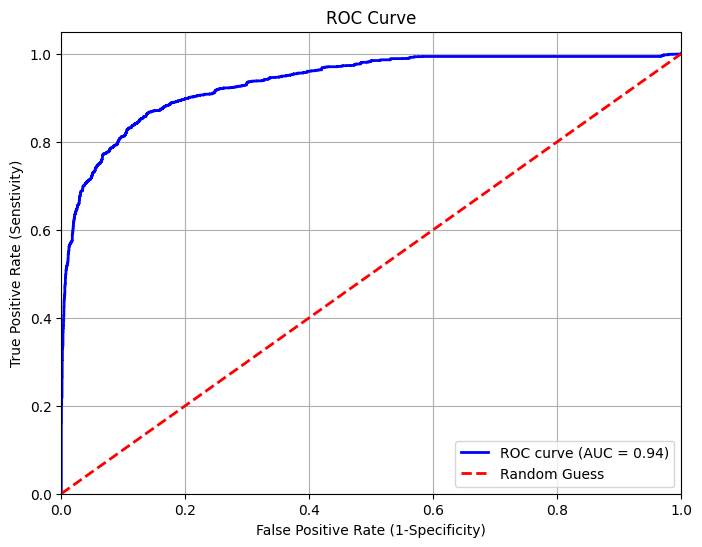

Number predicted resistant = 3651. Number labeled R = 3685
Number predicted susceptible = 3349. Number labeled S = 3315
Sensitivity: 0.86
Specificity: 0.86


(0.8648575305291724, 0.8600301659125189)

In [41]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.train_loader)

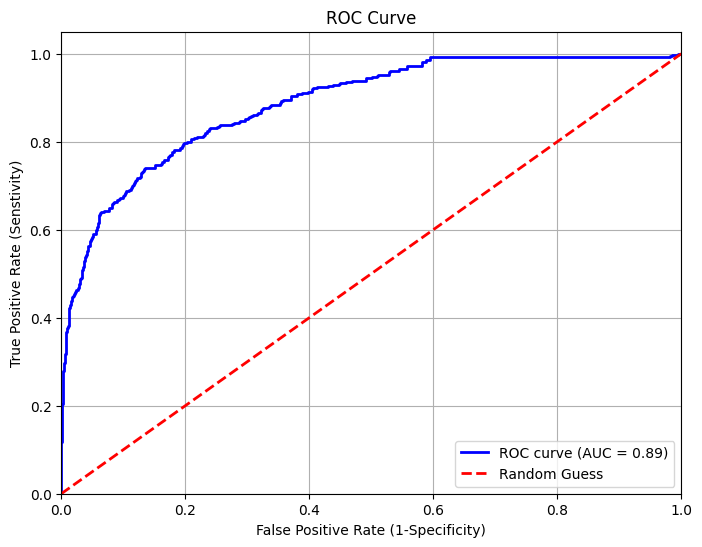

Number predicted resistant = 1615. Number labeled R = 1533
Number predicted susceptible = 1385. Number labeled S = 1467
Sensitivity: 0.82
Specificity: 0.76


(0.8238747553816047, 0.7600545330606681)

In [40]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.test_loader)

### Evaluate against raw set of mutations

In [34]:
# model = torch.load('saved_models/carter_ds_aug/pnca-sweep-1/awtki903/earnest-sweep-37')
# model = torch.load('saved_models/carter_ds_aug/pnca-sweep-1/awtki903/worldly-sweep-49')
cd = 10.79808

In [35]:
def convert_mutations_to_samples(mutations_df):
    out_df = pd.DataFrame(columns=['phenotype_label','number_resistant_mutations', 'number_susceptible_mutations', 'allele'])

    for idx, row in mutations_df.iterrows():
    
        sample = copy.deepcopy(pnca)
        # reassign amino acid to mutated amino acid
        sample.amino_acid_sequence[sample.amino_acid_number==row.AMINO_ACID] = row.ALT
        
        sequence = ''.join(i for i in sample.amino_acid_sequence)
        
        if row.CONSISTENT_PHENOTYPE == 'R':
            number_resistant_mutations = 1
            number_susceptible_mutations = 0
            phenotype_label = 'R'
        else:
            number_resistant_mutations = 0
            number_susceptible_mutations = 1
            phenotype_label = 'S'
            
        out_df.loc[len(out_df)] = [phenotype_label, number_resistant_mutations, number_susceptible_mutations, sequence]
    
    return out_df

In [36]:
from torch_geometric.data import DataLoader

real_train_sequences = convert_mutations_to_samples(mutations_dict['train'])

real_pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                     lig_resname='PZA', 
                     self_loops=False,
                     cutoff_distance=cd)

real_pnca.gen_dataset(
        'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS', 
        sequences=real_train_sequences,
        edge_weights= '1-(dist/cutoff)',
        normalise=False
        )

real_train_loader = DataLoader(real_pnca.dataset, batch_size=256, shuffle=True)

100%|██████████| 464/464 [00:03<00:00, 134.92it/s]


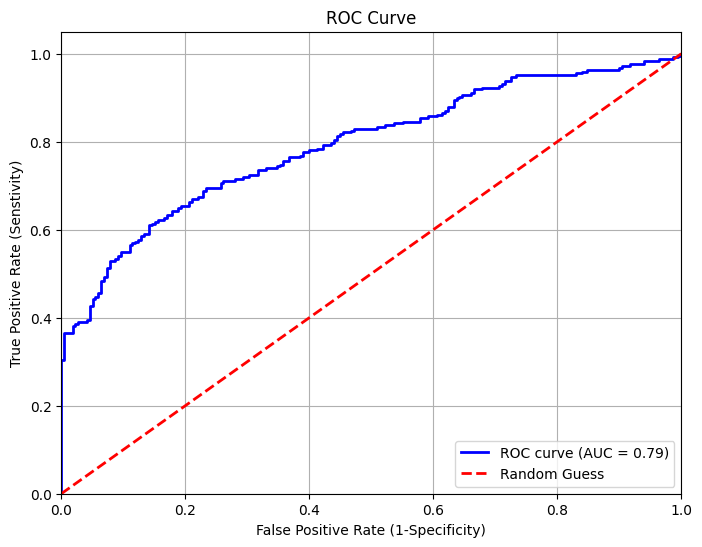

Number predicted resistant = 176. Number labeled R = 246
Number predicted susceptible = 288. Number labeled S = 218
Sensitivity: 0.60
Specificity: 0.87


(0.5975609756097561, 0.8669724770642202)

In [74]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, real_train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, real_train_loader)

In [37]:
real_test_sequences = convert_mutations_to_samples(mutations_dict['test'])

real_pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                     lig_resname='PZA', 
                     self_loops=False,
                     cutoff_distance=cd)

real_pnca.gen_dataset(
        'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS', 
        sequences=real_test_sequences,
        edge_weights= '1-(dist/cutoff)',
        normalise=False
        )

real_test_loader = DataLoader(real_pnca.dataset, batch_size=256, shuffle=True)

100%|██████████| 200/200 [00:01<00:00, 133.50it/s]


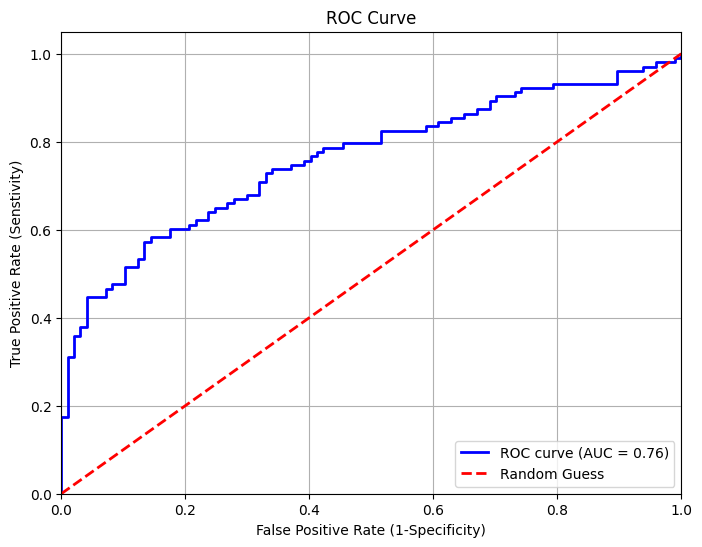

Number predicted resistant = 81. Number labeled R = 103
Number predicted susceptible = 119. Number labeled S = 97
Sensitivity: 0.61
Specificity: 0.81


(0.6116504854368932, 0.8144329896907216)

In [76]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, real_test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, real_test_loader)

In [38]:
# write singletons train and test dfs to csvs

real_train_sequences.to_csv('../data/real_train_sequences.csv', index=False)
real_test_sequences.to_csv('../data/real_test_sequences.csv', index=False)

### Rerun with 1 as output dim

In [14]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 64
hidden_channels = 64
output_channels = 1
learning_rate = 5e-5
wd = 1e-5
learning_rate = 1e-3
wd = 5e-5
epochs = 400

model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=sequences_dict,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    # edge_weight_func = '1-(dist/cutoff)',
    edge_weight_func= 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    output_channels = output_channels,
    normalise_ews=True,
    wandb_params={
        'use_wandb' : True,
        'wandb_project' : 'PncA outputdim = 1',
        'wandb_name' : f'test1',
        'n_samples' : n_samples
    }
)

100%|██████████| 3000/3000 [00:23<00:00, 129.66it/s]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch: 010, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6923
Epoch: 020, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6924
Epoch: 030, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6923
Epoch: 040, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6914, Test Loss: 0.6925
Epoch: 050, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6916, Test Loss: 0.6925
Epoch: 060, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6924
Epoch: 070, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6924
Epoch: 080, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6898, Test Loss: 0.6924
Epoch: 090, Train Acc: 0.4920, Test Acc: 0.4807, Train Loss: 0.6818, Test Loss: 0.6935
Epoch: 100, Train Acc: 0.5374, Test Acc: 0.4903, Train Loss: 0.6631, Test Loss: 0.6962
Epoch: 110, Train Acc: 0.5707, Test Acc: 0.5400, Train Loss: 0.6426, Test Loss: 0.6806
Epoch: 120, Train Acc: 0.5797, Test Acc: 0.

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Test Accuracy,▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▃▆▇▇▇▇▇▄▆█▇█▄▇▃▅▄▅▆▇█▇█
Test Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▁▃▄▃▆▁▅▁▂▁▃▄▇▆▆█
Train Accuracy,▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▄▆▆▇▇▇▆▄▆▇▇█▅█▄▆▅▅▇████
Train Loss,██████████▇▇▆▆▆▆▆▆▄▄▃▂▃▃▅▄▅▃▁▅▁▅▄▅▄▂▁▁▂▁
Test Accuracy,0.67
Test Loss,1.63287
Train Accuracy,0.75943
Train Loss,0.46085


In [18]:
model.train_sequences = train_sequences
model.train_mutations = train_mutations
model.test_sequences = test_sequences
model.test_mutations = test_mutations

torch.save(model, f'saved_models/outputdim_1_n{n_samples}_aug_split_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

In [6]:
# model = torch.load('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/tb-pnca-gnn/dd_pnca/saved_models/outputdim_1_n10000_aug_split_seed42_2024_11_25_133517')
model = torch.load('saved_models/carter_ds_aug/pnca-sweep-1/jbbvi8as/misty-sweep-156')

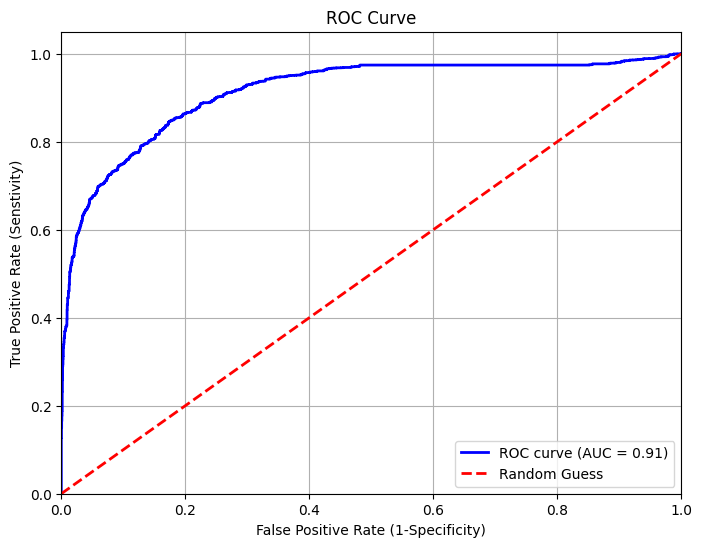

Number predicted resistant = 3616. Number labeled R = 3685
Number predicted susceptible = 3384. Number labeled S = 3315
Sensitivity: 0.83
Specificity: 0.83


(0.83202170963365, 0.8340874811463047)

In [7]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.train_loader)

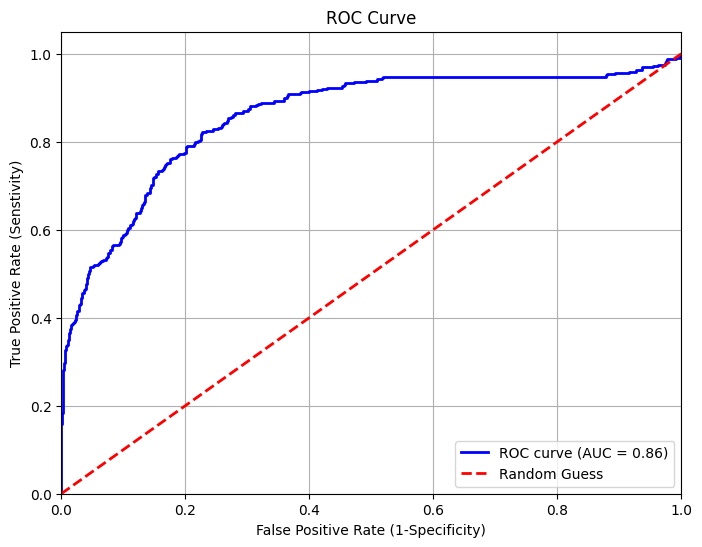

Number predicted resistant = 1476. Number labeled R = 1533
Number predicted susceptible = 1524. Number labeled S = 1467
Sensitivity: 0.77
Specificity: 0.80


(0.7736464448793215, 0.8023176550783913)

In [8]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.test_loader)